In [1]:
#%env CUDA_VISIBLE_DEVICES=1

In [2]:
import torch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from era_data import TabletEraDataset
from era_model import EraClassifier
from glob import glob
from era_data import TabletPeriodDataset
import pandas as pd
from matplotlib import pyplot as plt
from itertools import islice
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm, trange
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression

# Load data and model

In [5]:
IMG_DIR = 'output/images_preprocessed'

In [6]:
! ls lightning_logs

genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping
genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Spet_18_blur
period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked
period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked_blur
period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked_blurvae-conv
period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked_blurvae-convvae-conv
period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping
period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping-1
period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Spet_17_blur
period_clf_bs16_lr5e-05_3epochs-resnet50-103384_samples-preprocessed2
period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-masked
period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-preprocessed2
period_clf_bs16_lr5e-05_5epochs-resnet50-97640_samples-masked
period_clf_bs16_lr5e-

In [7]:
VERSION_NAME = 'period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping-1'

In [8]:
ckpt_fns = glob('lightning_logs/*/checkpoints/*')
ckpt_fns

['lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked/checkpoints/epoch=0-step=6070.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked/checkpoints/epoch=14-step=91078.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked_blur/checkpoints/epoch=14-step=91078.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked_blurvae-conv/checkpoints/epoch=0-step=5944.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked_blurvae-conv/checkpoints/epoch=49-step=297200.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-masked/checkpoints/epoch=2-step=18214-v1.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-masked/checkpoints/epoch=2-step=18214.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-preprocessed2/checkpoints/epoch=2-step=18214.ckpt',
 'lightning_logs

In [9]:
CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping-1/checkpoints/epoch=4-step=26716.ckpt'

In [10]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES) + 2
num_classes

24

In [11]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 857 ms, sys: 530 ms, total: 1.39 s
Wall time: 6.42 s


In [12]:
model.to(device);

In [13]:
model.eval();

In [14]:
### make sure era_data.py file, TabletPeriodDataset's method "__get_item__" returns the PERIOD, not the period

train_ids = pd.read_csv(f'output/clf_ids/period-train-{VERSION_NAME}.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [15]:
len(train_ids), len(test_ids)

(97140, 500)

In [16]:
ds_train = TabletPeriodDataset(IDS=train_ids, IMG_DIR=IMG_DIR, mask=True)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 97640 IDS down to provided 97140...
Filtering 97640 IDS down to provided 500...


# Calculate predictions

In [17]:
from itertools import islice
import scipy

In [18]:
# dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [19]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [20]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [21]:
y_true.shape, logits.shape

((489,), (489, 24))

In [22]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [23]:
y_pred.shape, y_prob.shape

((489,), (489, 24))

In [24]:
(y_pred == y_true).mean()

0.7382413087934561

# Check metrics

In [25]:
from collections import Counter

In [26]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
    
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [27]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'
explain('Neo-Babylonian')

'Neo-Babylonian (I)'

In [28]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [29]:
idx2period[0], idx2period[5]

('other', 'Neo-Babylonian')

In [30]:
indices = list(set(y_true) | set(y_pred))
print(len(indices))
print(indices)
PERIOD_LABELS = [explain(idx2period[i]) for i in indices]
print(PERIOD_LABELS)

19
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED IIIa (EB)', 'Hellenistic (I)', 'Middle Elamite (MLB)', 'Middle Hittite (MLB)']


In [31]:
print(classification_report(y_true, y_pred, target_names=PERIOD_LABELS))

                            precision    recall  f1-score   support

                 other (?)       0.33      0.33      0.33         3
               Ur III (EB)       0.86      0.84      0.85       140
          Neo-Assyrian (I)       0.96      0.95      0.96       109
      Old Babylonian (MLB)       0.56      0.71      0.63        91
   Middle Babylonian (MLB)       0.48      0.40      0.44        35
        Neo-Babylonian (I)       0.44      0.30      0.36        23
         Old Akkadian (EB)       0.79      0.61      0.69        18
            Achaemenid (I)       0.64      0.70      0.67        10
Early Old Babylonian (MLB)       1.00      0.22      0.36         9
              ED IIIb (EB)       0.60      0.60      0.60        15
     Middle Assyrian (MLB)       0.50      0.38      0.43         8
        Old Assyrian (MLB)       0.73      0.92      0.81        12
             Uruk III (EB)       0.50      0.60      0.55         5
            Lagash II (EB)       1.00      0.80

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [32]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_true).items() if v >= 10})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (9)


[(1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (7, 'Achaemenid (I)'),
 (9, 'ED IIIb (EB)'),
 (11, 'Old Assyrian (MLB)')]

In [33]:
y_true_c = y_true.copy()
y_true_c[~np.isin(y_true, COMMON_LABELS)] = 0
print((~np.isin(y_true, COMMON_LABELS)).mean(), 'changed to "other"')

0.0736196319018405 changed to "other"


In [34]:
y_pred_c = y_pred.copy()
y_pred_c[~np.isin(y_pred, COMMON_LABELS)] = 0
print((~np.isin(y_pred, COMMON_LABELS)).mean(), 'changed to "other"')

0.05725971370143149 changed to "other"


In [35]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'ED IIIb (EB)', 'Old Assyrian (MLB)']


In [36]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                         precision    recall  f1-score   support

              other (?)       0.64      0.50      0.56        36
            Ur III (EB)       0.86      0.84      0.85       140
       Neo-Assyrian (I)       0.96      0.95      0.96       109
   Old Babylonian (MLB)       0.56      0.71      0.63        91
Middle Babylonian (MLB)       0.48      0.40      0.44        35
     Neo-Babylonian (I)       0.44      0.30      0.36        23
      Old Akkadian (EB)       0.79      0.61      0.69        18
         Achaemenid (I)       0.64      0.70      0.67        10
           ED IIIb (EB)       0.60      0.60      0.60        15
     Old Assyrian (MLB)       0.73      0.92      0.81        12

               accuracy                           0.74       489
              macro avg       0.67      0.65      0.66       489
           weighted avg       0.75      0.74      0.74       489



In [37]:
cm = confusion_matrix(y_true_c, y_pred_c)
cm # rows: ground truth; cols: prediction

array([[ 18,   1,   0,   8,   2,   2,   1,   0,   3,   1],
       [  3, 117,   0,  14,   2,   1,   2,   0,   1,   0],
       [  1,   1, 104,   2,   0,   0,   0,   0,   1,   0],
       [  1,   8,   2,  65,   8,   4,   0,   2,   0,   1],
       [  0,   4,   2,  12,  14,   1,   0,   0,   1,   1],
       [  4,   2,   0,   6,   1,   7,   0,   2,   0,   1],
       [  0,   3,   0,   3,   1,   0,  11,   0,   0,   0],
       [  0,   0,   0,   1,   1,   1,   0,   7,   0,   0],
       [  1,   0,   0,   5,   0,   0,   0,   0,   9,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  11]])

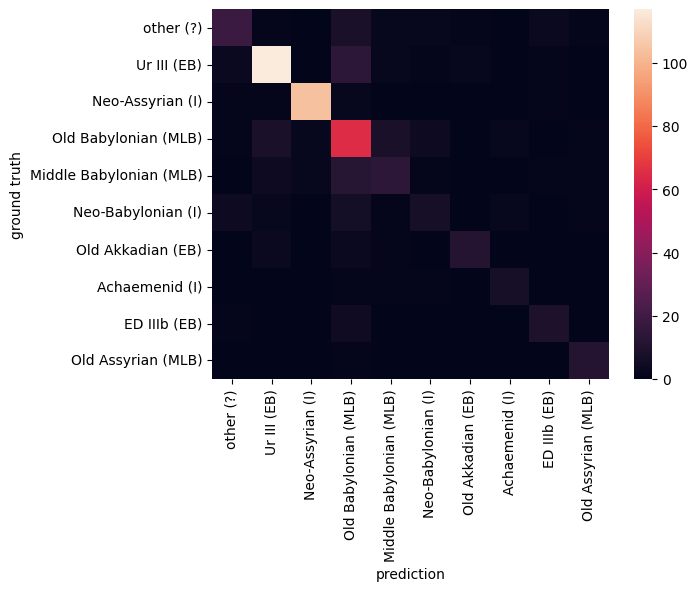

In [38]:
sns.heatmap(cm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [39]:
cm_rownorm = (cm / cm.sum(axis=1)[:, None])

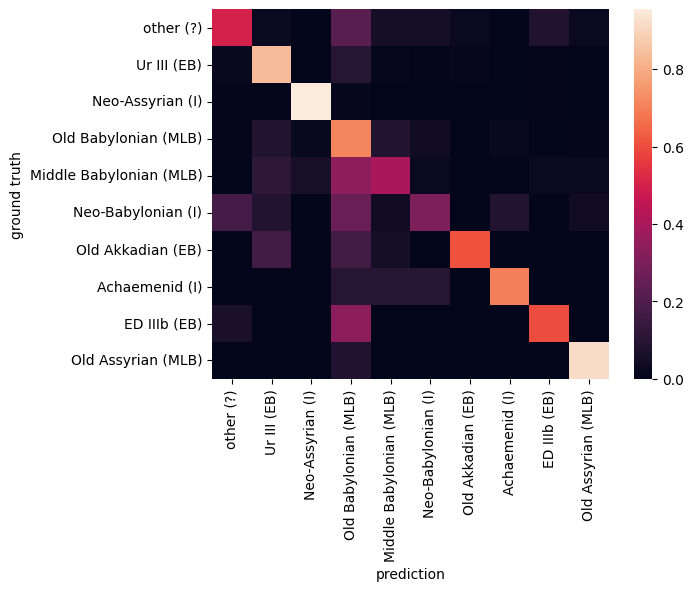

In [40]:
sns.heatmap(cm_rownorm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [41]:
cm_df = pd.DataFrame(cm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),ED IIIb (EB),Old Assyrian (MLB)
other (?),18,1,0,8,2,2,1,0,3,1
Ur III (EB),3,117,0,14,2,1,2,0,1,0
Neo-Assyrian (I),1,1,104,2,0,0,0,0,1,0
Old Babylonian (MLB),1,8,2,65,8,4,0,2,0,1
Middle Babylonian (MLB),0,4,2,12,14,1,0,0,1,1
Neo-Babylonian (I),4,2,0,6,1,7,0,2,0,1
Old Akkadian (EB),0,3,0,3,1,0,11,0,0,0
Achaemenid (I),0,0,0,1,1,1,0,7,0,0
ED IIIb (EB),1,0,0,5,0,0,0,0,9,0
Old Assyrian (MLB),0,0,0,1,0,0,0,0,0,11


In [42]:
cm_rn_df = pd.DataFrame(cm_rownorm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_rn_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),ED IIIb (EB),Old Assyrian (MLB)
other (?),0.500000,0.027778,0.000000,0.222222,0.055556,0.055556,0.027778,0.000000,0.083333,0.027778
Ur III (EB),0.021429,0.835714,0.000000,0.100000,0.014286,0.007143,0.014286,0.000000,0.007143,0.000000
Neo-Assyrian (I),0.009174,0.009174,0.954128,0.018349,0.000000,0.000000,0.000000,0.000000,0.009174,0.000000
Old Babylonian (MLB),0.010989,0.087912,0.021978,0.714286,0.087912,0.043956,0.000000,0.021978,0.000000,0.010989
Middle Babylonian (MLB),0.000000,0.114286,0.057143,0.342857,0.400000,0.028571,0.000000,0.000000,0.028571,0.028571
Neo-Babylonian (I),0.173913,0.086957,0.000000,0.260870,0.043478,0.304348,0.000000,0.086957,0.000000,0.043478
Old Akkadian (EB),0.000000,0.166667,0.000000,0.166667,0.055556,0.000000,0.611111,0.000000,0.000000,0.000000
Achaemenid (I),0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,0.700000,0.000000,0.000000
ED IIIb (EB),0.066667,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000
Old Assyrian (MLB),0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.916667


In [43]:
#cm_df.loc['Early Old Babylonian (MLB)']

In [44]:
#cm_rn_df.loc['Early Old Babylonian (MLB)']

# Hierarchical clustering on confusion matrix

In [ ]:
from scipy.cluster import hierarchy

Y = hierarchy.distance.pdist(cm_rownorm, metric='euclidean')

Z = hierarchy.linkage(Y, method='single')

ax = hierarchy.dendrogram(Z, show_contracted=True, labels=PERIOD_LABELS_C, orientation='right')

# Clustering feature vectors using model as feature extractor

In [49]:
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt

In [50]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [51]:
model.core.avgpool.register_forward_hook(get_activation('ap'))
# model.core.fc.register_forward_hook(get_activation('fc'))

In [52]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)

In [53]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [54]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)
#     y_true = np.hstack(y_true)
#     logits = np.vstack(logits)
#     return logits, y_true

In [55]:
feats_train = extract_features(dl_train)

  0%|          | 0/5943 [00:00<?, ?it/s]

In [56]:
feats = extract_features(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [57]:
feats.shape

(489, 2048)

In [58]:
%time F = TSNE(n_components=2, init='pca').fit_transform(feats)
# learning_rate='auto' -- https://www.pythonfixing.com/2021/11/fixed-sklearnmanifoldtsne-typeerror.html

CPU times: user 8.66 s, sys: 996 ms, total: 9.66 s
Wall time: 2.09 s


In [59]:
%time F2 = Isomap(n_components=10).fit_transform(feats)

CPU times: user 265 ms, sys: 128 ms, total: 392 ms
Wall time: 5.23 s


In [60]:
F2

array([[-20.068747  ,   9.976312  ,   2.5354412 , ...,  -6.0466075 ,
         -1.7530713 ,   4.9336686 ],
       [-21.591845  ,  12.33865   ,  -8.981942  , ...,   4.1892204 ,
          9.69103   ,   8.440093  ],
       [-13.456673  ,   2.1480124 ,  -4.2860923 , ...,  -7.235338  ,
          3.944767  ,   2.7947319 ],
       ...,
       [  0.68271214, -14.734306  ,   3.8063092 , ...,   4.945752  ,
          4.8431554 ,  -2.6388273 ],
       [-27.121532  ,  12.292947  , -18.39332   , ...,   2.015476  ,
         -3.1826634 ,  -4.6911225 ],
       [-12.500088  ,  -6.1503797 , -12.489576  , ...,   8.627166  ,
          9.928526  ,   0.46957153]], dtype=float32)

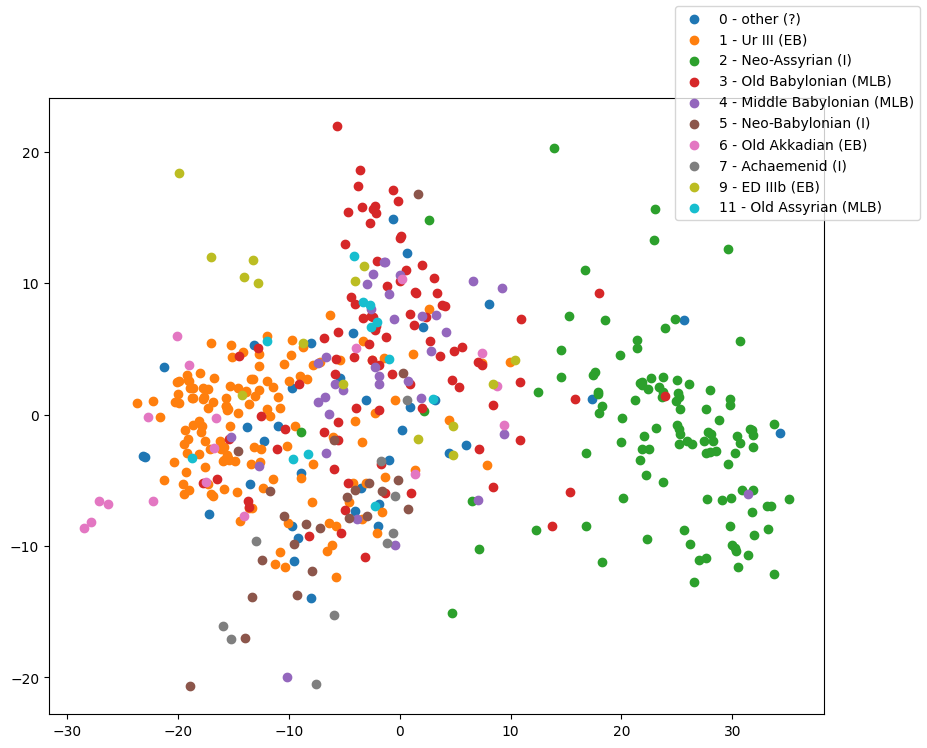

In [61]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for period in set(y_true_c):
    ax.scatter(F2[y_true_c == period, 0], F2[y_true_c == period, 4], label=f'{period} - {explain(idx2period[period])}')
fig.legend();

In [62]:
list(idx2period.values())

['other',
 'Ur III',
 'Neo-Assyrian',
 'Old Babylonian',
 'Middle Babylonian',
 'Neo-Babylonian',
 'Old Akkadian',
 'Achaemenid',
 'Early Old Babylonian',
 'ED IIIb',
 'Middle Assyrian',
 'Old Assyrian',
 'Uruk III',
 'Proto-Elamite',
 'Lagash II',
 'Ebla',
 'ED IIIa',
 'Hellenistic',
 'ED I-II',
 'Middle Elamite',
 'Middle Hittite',
 'Uruk IV']

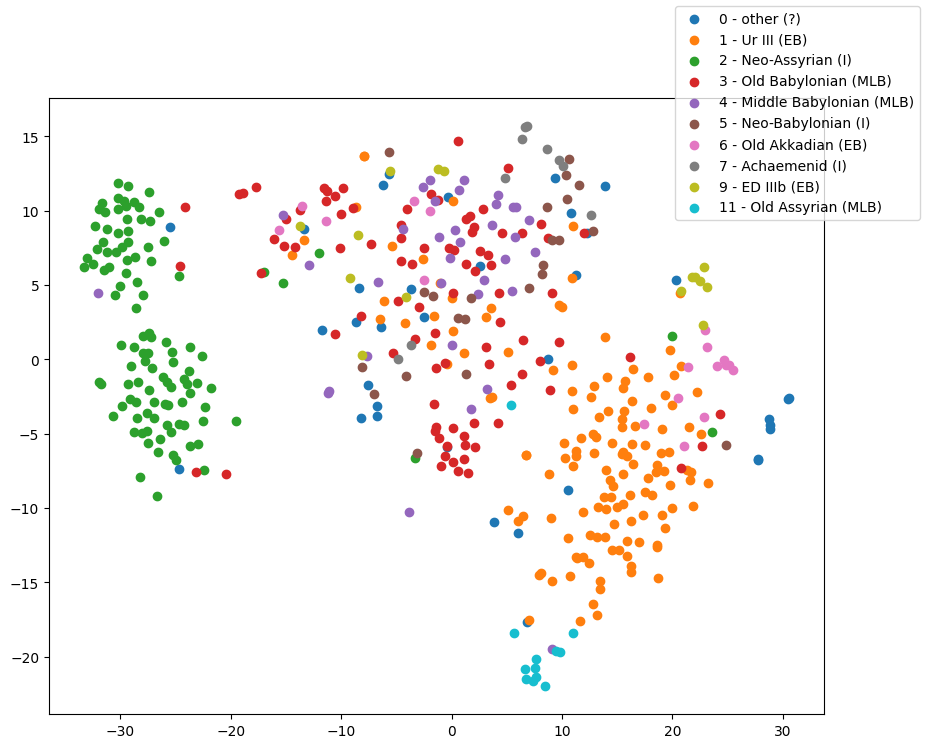

In [63]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for period in set(y_true_c):
    ax.scatter(F[y_true_c == period, 0], F[y_true_c == period, 1], label=f'{period} - {explain(idx2period[period])}')
fig.legend();

In [68]:
plt2 = umap.plot.points(mapper, labels=np.array([idx2period[idx] for idx in y_true_c]), color_key_cmap='Paired', background= 'black')

NameError: name 'umap' is not defined

In [69]:
inv_transformed_points[0].shape

NameError: name 'inv_transformed_points' is not defined

In [64]:
from matplotlib.gridspec import GridSpec
labels = np.array([y_true_c])
corners = np.array([
    [0, 3], 
    [0, 5],  
    [8, 2], 
    [10, 6], 
])


test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

inv_transformed_points = mapper.inverse_transform(test_pts)

# Set up the grid
fig = plt.figure(figsize=(20,12))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=labels.astype(np.int32), cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(64, 32))
        digit_axes[i, j].set(xticks=[], yticks=[])

NameError: name 'mapper' is not defined

In [65]:
# green
np.where(y_true == 2)

(array([150, 151, 152, 153, 154, 155, 156, 157, 158, 203, 269, 270, 271,
        282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 299, 321,
        322, 323, 324, 332, 340, 342, 355, 359, 360, 361, 362, 363, 364,
        365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
        378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
        391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
        404, 405, 406, 407, 408, 409, 416, 430, 431, 432, 433, 434, 435,
        436, 437, 438, 443, 445, 447, 451, 452, 453, 454, 455, 456, 457,
        458, 465, 467, 468, 469]),)

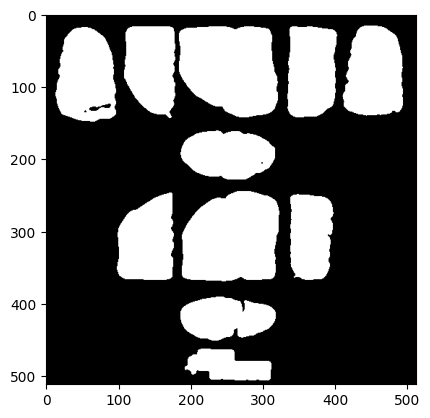

In [66]:
ID = np.random.choice(np.where(y_true == 2)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

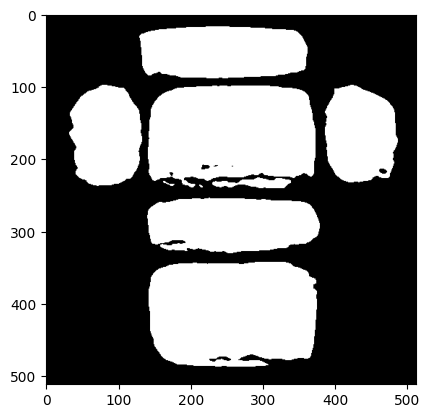

In [67]:
ID = np.random.choice(np.where(y_true == 5)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

# Visualize mistakes

In [68]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([ 16,  18,  28,  38,  39,  44,  46,  50,  59,  70,  74,  87,  92,
       100, 110, 114, 115, 116, 117, 126, 127, 130, 131, 132, 133, 134,
       135, 147, 165, 166, 169, 174, 177, 184, 185, 186, 190, 191, 192,
       195, 196, 201, 203, 206, 207, 208, 209, 211, 213, 215, 220, 221,
       226, 227, 228, 229, 233, 234, 238, 239, 240, 241, 242, 243, 244,
       246, 247, 248, 249, 253, 257, 259, 260, 261, 262, 265, 266, 267,
       268, 272, 279, 283, 296, 298, 302, 303, 305, 307, 308, 309, 314,
       324, 325, 327, 328, 329, 330, 331, 334, 339, 341, 342, 344, 345,
       348, 358, 415, 417, 418, 419, 424, 425, 429, 439, 440, 441, 443,
       448, 449, 461, 462, 463, 464, 466, 478, 483, 484, 486])

In [69]:
mistake_indices.shape

(128,)

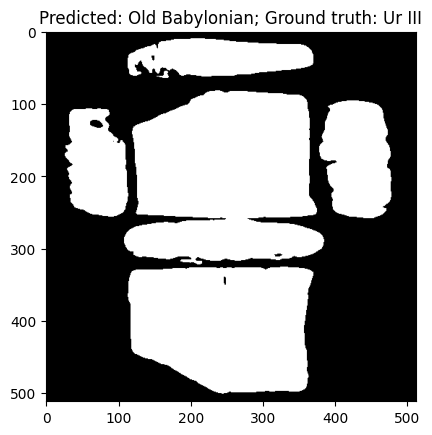

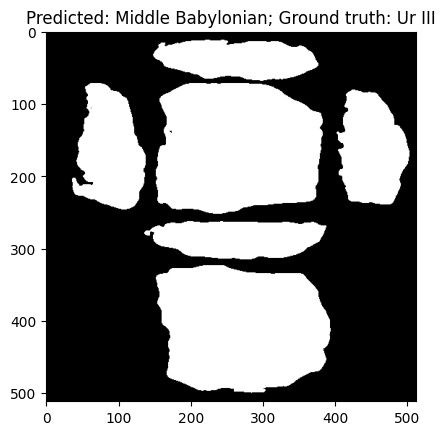

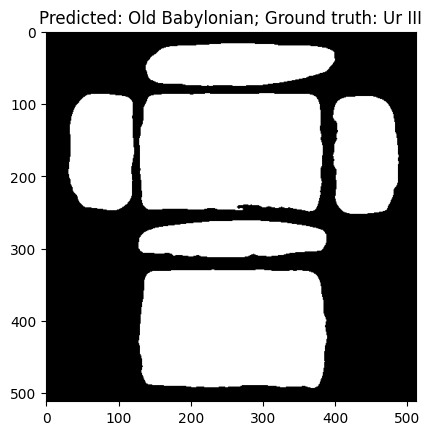

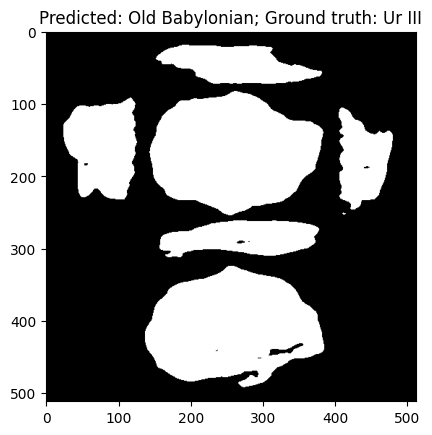

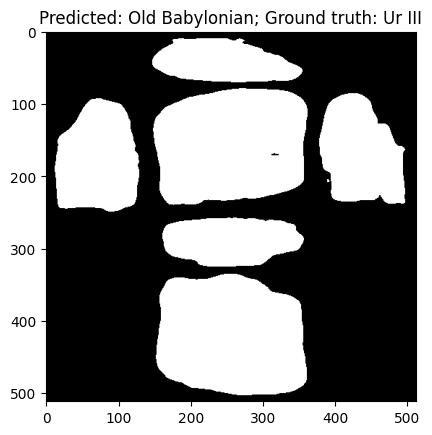

In [70]:
for idx in mistake_indices[:5]:
    
    X, y = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {idx2period[pred]}; Ground truth: {idx2period[y]}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [71]:
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [72]:
# def preprocess_transform(img):
#     return img

In [73]:
# def batch_predict(X):
#     assert len(X.shape) == 4
#     # Lime adds channel dimension (gray2rgb); we remove it
#     # it also requires float64 (double) but our model needs float32
#     X_gray = X[..., 0].astype(np.float32) / 255
#     logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
# #     probs = clf.predict_proba(logits)
#     probs = scipy.special.softmax(logits, axis=-1)
#     return probs

In [74]:
# explainer = lime_image.LimeImageExplainer()

In [75]:
# def explain_idx(idx):
#     X, y = ds_test[idx]
    
#     explanation = explainer.explain_instance(
#         X.astype(np.float64) * 255,
#         batch_predict,
#     #     top_labels=3,
#     #     hide_color=0,
#         batch_size=16,
#         num_samples=1000
#     )
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(
#         top_label,
#         positive_only=False,
#         num_features=20,
#         hide_rest=False
#     )
    
#     img_boundary = mark_boundaries(temp/255.0, mask)
    
#     print(f'Item {idx}:')
#     print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
#     print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(X, cmap='gray');
#     axs[1].imshow(img_boundary);
#     plt.show()

In [76]:
# for i in range(10):
#     explain_idx(i)